# From the paper

We attempt to reproduce and beat the results of "Distribution Regression with Sliced Wasserstein Kernels", https://arxiv.org/pdf/2202.03926.pdf 

In [1]:
import numpy as onp
import jax.numpy as jnp
import jax
from jax.config import config

run64 = False
if run64:
    config.update("jax_enable_x64", True)
    global_type = jnp.float64
else:
    global_type = jnp.float32

In [2]:
import joblib

In [3]:
import ott
from ott.geometry import pointcloud
from ott.core import sinkhorn
from ott.tools import transport

In [4]:
def get_indexes_support(n, m):
    rows = jnp.expand_dims(jnp.arange(n, dtype=jnp.float32), axis=1)
    rows = jnp.tile(rows, m) / (n-1)  # renormalize
    cols = jnp.expand_dims(jnp.arange(m, dtype=jnp.float32), axis=1)
    cols = jnp.tile(cols, n).T / (m-1)  # renormalize
    coords = jnp.stack([rows, cols], axis=-1)
    coords = jnp.reshape(coords, newshape=(n*m, 2))
    coords = coords*2. - 1.  # to [-1., 1.]
    return coords

In [5]:
import tensorflow as tf
# Hide any GPUs from TensorFlow. Otherwise TF might reserve memory and make
# it unavailable to JAX.
tf.config.experimental.set_visible_devices([], 'GPU')

In [6]:
def normalize_images(images):
    return images.astype('float32') / 255.

In [7]:
import matplotlib.pyplot as plt
import itertools

def vizualize_features(features, channels='first', *, plot_size=3, filename=None, **kwargs):
    if channels == 'last':
        features = jnp.transpose(features, axes=[2, 3, 0, 1])
    n, m = features.shape[2], features.shape[3]
    n_row, n_col = features.shape[0], features.shape[1]
    imgs = [features[i,j] for i, j in itertools.product(range(n_row), range(n_col))]
    _, axs = plt.subplots(n_row, n_col, figsize=(n_col*plot_size, n_row*plot_size))
    if n_row == 1 and n_col == 1:
        axs = [axs]
    else:
        axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        ax.imshow(img, **kwargs)
    plt.show()
    if filename is not None:
        plt.savefig(filename)
        if plot_wandb:
            wandb.save(filename)

In [8]:
import os
os.environ['WANDB_NOTEBOOK_NAME'] = 'SinkhornKernel-mnist.ipynb'
import wandb
wandb.login()

wandb: Currently logged in as: algue (use `wandb login --relogin` to force relogin)


True

In [9]:
from types import SimpleNamespace
import math

debug = False
plot_wandb = not debug
config = SimpleNamespace(
    dataset_name='mnist',
    train_size=1300,
    test_size=1000,
    epsilon=2e-3,
    mu_type='uniform',
    image_size=28,
    jolib_mem=False,
    rotation_range=0,
    translation_range=6,
    geometry='grid',
    lbda=0.1
)
if plot_wandb:
    wandb.init(project="sinkhorn_kernel_mnist", config=config.__dict__, save_code=True)
    table = wandb.Table(columns=['Algo', 'Type', 'Kfold acc', 'Test acc', 'Best params'])
print(config)

namespace(dataset_name='mnist', train_size=100, test_size=1000, epsilon=0.002, mu_type='uniform', image_size=28, jolib_mem=False, rotation_range=0, translation_range=6, geometry='grid', lbda=0.1)


In [10]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist

if config.dataset_name == 'mnist':
    loader = mnist
elif config.dataset_name == 'fashion_mnist':
    loader = fashion_mnist
(x_train, y_train), (x_test, y_test) = loader.load_data()
x_train = normalize_images(x_train)
x_test = normalize_images(x_test)

In [11]:
all_indices = get_indexes_support(config.image_size, config.image_size)

## Sinkhorn Kernel

In [12]:
def filter_nonzero_pixels(img, support):
    flat_img = img.flatten()
    indices = flat_img.nonzero()
    cloud_weight = flat_img[indices]
    cloud_weight = cloud_weight / cloud_weight.sum()
    cloud_support = support[indices]
    return cloud_weight, cloud_support

def image_average(images, support):
    avg_img = images.mean(axis=0)
    flat_mean = avg_img.flatten()
    num_non_zero = int(jax.vmap(jnp.count_nonzero)(images).mean())
    print(f"Keep {num_non_zero} pixels")
    higher_indices = jnp.argsort(flat_mean)[::-1]
    threshold = flat_mean[higher_indices[num_non_zero]]
    mu_support = support[higher_indices[:num_non_zero]]
    mu_weights = flat_mean[higher_indices[:num_non_zero]]
    mu_weights = mu_weights / mu_weights.sum()
    sparse_img = jnp.where(avg_img < threshold, 0., avg_img)
    digits = jnp.stack([avg_img, sparse_img])[jnp.newaxis,:,:,:]
    vizualize_features(digits)
    return mu_weights, mu_support

In [13]:
def mu_uniform(images, support):
    uniform = jnp.ones(images.shape[1:])
    uniform = uniform.flatten()
    uniform = uniform / uniform.sum()
    return uniform, support

In [14]:
if config.mu_type == 'euclidian':
    mu_weights, mu_support = image_average(x_train, all_indices)
elif config.mu_type == 'uniform':
    mu_weights, mu_support = mu_uniform(x_train, all_indices)

In [15]:
import math

def get_img_from_g(g_embedding, mu_support):
    img_g = onp.full((config.image_size,config.image_size), fill_value=-jnp.inf)
    for idx, value in zip(mu_support, g_embedding):
        i, j = idx[0], idx[1]
        i = round((i+1)*(config.image_size-1)/2)
        j = round((j+1)*(config.image_size-1)/2)
        img_g[i,j] = value
    return img_g

In [16]:
def normalize_distribution(image):
    weights = image.sum(keepdims=True)
    image = image / weights
    return jnp.array(image)

In [17]:
import ott
from ott.geometry.pointcloud import PointCloud
from ott.core import sinkhorn
from ott.tools import transport

def get_cloud_embedding(img, mu_weight, mu_support, epsilon, **kwargs):
    img = normalize_distribution(img)
    img_weight, img_support = filter_nonzero_pixels(img, all_indices)
    geom = PointCloud(img_support, mu_support, epsilon=epsilon)
    ot_sol = sinkhorn.sinkhorn(geom, img_weight, mu_weight, **kwargs)
    return ot_sol.g, ot_sol

In [18]:
from ott.geometry import grid

def fill_void(img, lbda):
    eps  = 0.1 / (img.shape[-2]*img.shape[-1])
    mask = jnp.where(img > 0, 0., 1.)
    mask = mask / (jnp.sum(mask, axis=[-2,-1], keepdims=True) + eps)
    img = img + lbda * mask
    img = img / jnp.sum(img, axis=[-2,-1], keepdims=True)
    return img

def get_grid_embedding(img, mu_weight, mu_support, epsilon, **kwargs):
    img_weight = fill_void(img, lbda=config.lbda).flatten()
    geom = grid.Grid(grid_size=[img.shape[-2], img.shape[-1]], epsilon=epsilon)
    ot_sol = sinkhorn.sinkhorn(geom, img_weight.flatten(), mu_weight.flatten(), **kwargs)
    return ot_sol.g, ot_sol

In [19]:
if config.geometry == 'cloud':
    get_img_embedding = get_cloud_embedding
elif config.geometry == 'grid':
    get_img_embedding = get_grid_embedding

In [20]:
from skimage.transform import rotate, AffineTransform, warp, resize
import tqdm

def shift(image, translation):
    transform = AffineTransform(translation=translation)
    shifted = warp(image, transform, preserve_range=True)
    shifted = shifted.astype(image.dtype)
    return shifted

def evaluate_embeddings(x_sample, epsilon, filename=None, transform=None):
    if transform is None:
        shifted_small = shift(onp.array(x_sample), translation=(3, 0))
        shifted_large = shift(onp.array(x_sample), translation=(0, 6))
        rotated_15 = rotate(onp.array(x_sample), angle=15)
        rotated_30 = rotate(onp.array(x_sample), angle=-30)
        transformed_sample = [x_sample, shifted_small, shifted_large, rotated_15, rotated_30]
    else:
        transformed_sample = [transform(x_sample) for _ in range(4)]
    imgs = []
    x_sample_g, _ = get_img_embedding(x_sample, mu_weights, mu_support, epsilon)
    for img in tqdm.tqdm(transformed_sample):
        g_embeddings, ot_sol = get_img_embedding(img, mu_weights, mu_support, epsilon=epsilon)
        img_g = get_img_from_g(g_embeddings, mu_support)
        delta_g = get_img_from_g(g_embeddings - x_sample_g, mu_support)
        if x_sample.shape != img.shape:
            img = resize(img, x_sample.shape)
        delta_euclidian = img - x_sample
        imgs.append(jnp.stack([img, img_g, delta_g, delta_euclidian]))
    imgs = jnp.stack(imgs)
    imgs = jnp.transpose(imgs, axes=[1,0,2,3])
    vizualize_features(imgs, plot_size=2, cmap='plasma', filename=filename)

In [21]:
from skimage.transform import EuclideanTransform
from skimage.util import crop

def transform_fn(rotation_range, translation_range, crop_back=None, extend_size=3):
    crop_back = config.geometry == 'grid'
    def transform(image):
        image = onp.pad(image, (extend_size, extend_size), 'constant', constant_values=(0, 0))
        rotation = onp.random.uniform(-rotation_range, rotation_range) / 180 * onp.pi
        translation = onp.random.uniform(-translation_range, translation_range, size=2)
        euclidian = EuclideanTransform(rotation=rotation, translation=translation)
        image = warp(image, euclidian)
        a = onp.random.randint(0, 2*extend_size+1)
        b = onp.random.randint(0, 2*extend_size+1)
        crop_width = [(a, 2*extend_size-a), (b, 2*extend_size-b)]
        if crop_back:
            image = crop(image, crop_width=crop_width)
        return image
    return transform

In [22]:
default_transform = transform_fn(rotation_range=config.rotation_range, translation_range=0)

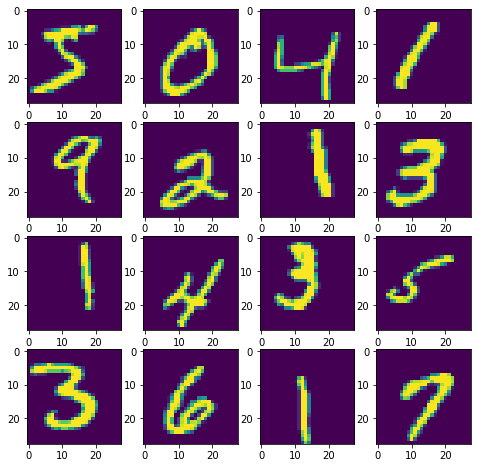

In [23]:
transformed = onp.array([default_transform(x_sample) for x_sample in x_train[:16]]).reshape((4, 4,)+x_train.shape[1:])
vizualize_features(transformed, plot_size=2)

In [24]:
x_sample = jnp.array(x_train[onp.random.choice(len(x_train))])

100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:28<00:00,  7.24s/it]


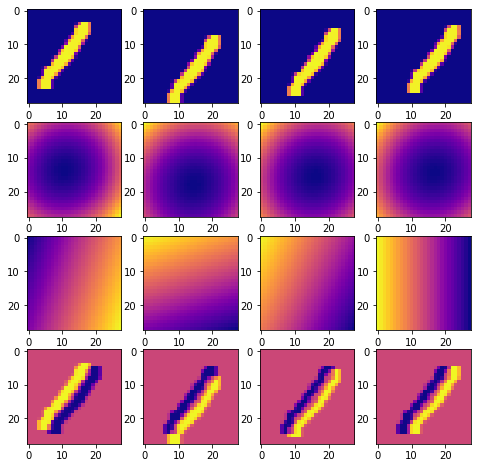

<Figure size 432x288 with 0 Axes>

In [25]:
evaluate_embeddings(x_sample, epsilon=1., filename=f'embedding_{1.}.png', transform=default_transform)

100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:34<00:00,  6.83s/it]


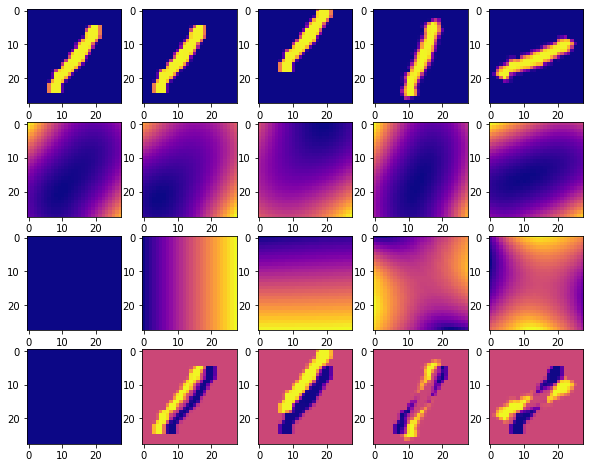

<Figure size 432x288 with 0 Axes>

In [26]:
evaluate_embeddings(x_sample, epsilon=1e-3, filename=f'embedding_{1e-3}.png')

In [27]:
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
import tqdm

def encode_imgs(x_ds, y_ds, ds_size, transform=None, filename=None):
    features = []
    raw = []
    labels = []
    try:
        pbar = tqdm.tqdm(total=ds_size)
        converged_hist = []
        for image, label in zip(*shuffle(x_ds, y_ds, n_samples=ds_size)):
            if transform is not None:
                image = transform(image)
            g_embeddings, ot_sol = get_img_embedding(jnp.array(image), mu_weights, mu_support, epsilon=config.epsilon)
            features.append(g_embeddings)
            labels.append(label)
            raw.append(image.ravel())
            converged_hist.append(ot_sol.converged)
            pbar.set_postfix({'converged':jnp.mean(jnp.array(converged_hist))})
            pbar.update()
        features = jnp.stack(features).reshape((len(features), -1))
        raw = jnp.stack(raw, axis=0).reshape((len(raw), -1))
        labels  = jnp.stack(labels)
    finally:
        pbar.close()
    if filename is not None:
        jnp.savez(filename, features=features, raw=raw, labels=labels)
    return features, raw, labels

In [28]:
features, raw, labels = encode_imgs(x_train, y_train, config.train_size, filename=f'train_{config.epsilon}')

100%|████████████████████████████████████████████████████████████| 100/100 [01:55<00:00,  1.15s/it, converged=1.0]


In [29]:
features_test, raw_test, labels_test = encode_imgs(x_test, y_test, config.test_size, filename=f'test_{config.epsilon}')

100%|██████████████████████████████████████████████████████████| 1000/1000 [20:41<00:00,  1.24s/it, converged=1.0]


<BarContainer object of 10 artists>

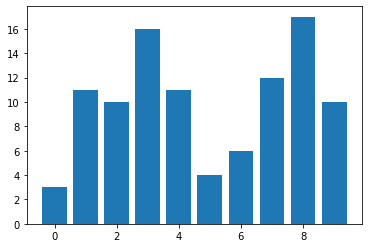

In [30]:
plt.bar(*onp.unique(labels, return_counts=True))

<BarContainer object of 10 artists>

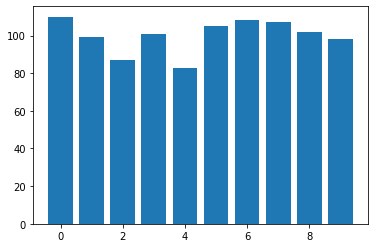

In [31]:
plt.bar(*onp.unique(labels_test, return_counts=True))

## Fit SVC

In [32]:
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [33]:
def grid_search_svc(x, labels):
    learner = Pipeline([('scaler', StandardScaler(with_std=False)), ('svc', SVC())])
    cv = GridSearchCV(learner, param_grid={'svc__gamma':10**onp.linspace(-4, 2, 12), 'svc__C':10**onp.linspace(-4, 4, 12)},
                      cv=5, scoring='accuracy',  # balanced learning so ok.
                      refit=True,  # refit best estimator found in grid search
                      n_jobs=12, verbose=1)  # keep 4 cores for other process running in parallel
    cv = cv.fit(onp.array(x).astype(jnp.float64), labels)
    return cv

In [34]:
grid_cv_features = grid_search_svc(onp.array(features).astype(jnp.float64), labels)
grid_cv_features.best_score_, grid_cv_features.best_params_

Fitting 5 folds for each of 144 candidates, totalling 720 fits


/home/lbethune/anaconda3/envs/dro/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


(0.8, {'svc__C': 10000.0, 'svc__gamma': 0.0012328467394420659})

In [35]:
best_features = grid_cv_features.best_estimator_
features_test_pred = best_features.predict(features_test)
features_test_acc = (features_test_pred == labels_test).mean()
print(f"{features_test_acc*100:.2f}")

71.00


In [36]:
if plot_wandb:
    table.add_data('svc', 'features', grid_cv_features.best_score_, features_test_acc, grid_cv_features.best_params_)

In [37]:
svc_raw = SVC()
grid_cv_raw = grid_search_svc(onp.array(raw).astype(jnp.float64), labels)
grid_cv_raw.best_score_, grid_cv_raw.best_params_

Fitting 5 folds for each of 144 candidates, totalling 720 fits


/home/lbethune/anaconda3/envs/dro/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


(0.78, {'svc__C': 65.79332246575683, 'svc__gamma': 0.0003511191734215131})

In [38]:
best_raw = grid_cv_raw.best_estimator_
raw_test_pred = best_raw.predict(raw_test)
raw_test_acc = (raw_test_pred == labels_test).mean()
print(f"{raw_test_acc*100:.2f}")

74.70


In [39]:
if plot_wandb:
    table.add_data('svc', 'raw', grid_cv_features.best_score_, raw_test_acc, grid_cv_features.best_params_)

## Transformation of MNIST
Use https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.EuclideanTransform


In [40]:
features_transform, raw_transform, labels_transform = encode_imgs(x_test, y_test, config.test_size, transform=transform, filename=f'transform_{config.epsilon}')

NameError: name 'transform' is not defined

In [ ]:
from skimage.transform import resize
raw_transform = onp.array([resize(img_raw, (28, 28)).flatten() for img_raw in raw_transform])

In [ ]:
plt.bar(*onp.unique(labels_transform, return_counts=True))

In [ ]:
best_features = grid_cv_features.best_estimator_
features_transform_pred = best_features.predict(features_transform)
features_transform_acc = (features_transform_pred == labels_transform).mean()
print(f"{features_transform_acc*100:.2f}")

In [ ]:
plt.bar(*onp.unique(features_transform_pred, return_counts=True))

In [ ]:
if plot_wandb:
    table.add_data('svc', 'features_transform', None, features_transform_acc, grid_cv_features.best_params_)

In [ ]:
best_raw = grid_cv_raw.best_estimator_
raw_transform_pred = best_raw.predict(raw_transform)
raw_transform_acc = (raw_transform_pred == labels_transform).mean()
print(f"{raw_transform_acc*100:.2f}")

In [ ]:
plt.bar(*onp.unique(raw_transform_pred, return_counts=True))

In [ ]:
if plot_wandb:
    table.add_data('svc', 'raw_transform', None, raw_transform_acc, grid_cv_raw.best_params_)

In [ ]:
wandb.finish()